In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%config InlineBackend.figure_format = 'retina'
sns.set_theme()

---

## Preprocessing

In [2]:
dtypes = {
    'country': 'category',
    'province': 'category',
    'variety': 'category',
    'region_1': 'category',
    'region_2': 'category',
    
    'winery': 'category',
    'designation': 'category',
    
    'description': 'str',

    'quality': 'float'
}
categorical_columns = [k for k,t in dtypes.items() if t=='category']
df = pd.read_csv('../datasets/competition_dataset/dev.tsv', sep='\t', dtype=dtypes,
                 usecols=dtypes.keys())

df = df.drop_duplicates().dropna(subset=['country', 'province'])

for col in categorical_columns:
    unk_cat = f"UNKNOWN_{col}"
    df[col] = df[col].cat.add_categories(unk_cat).fillna(unk_cat)

assert len(df) == 85025, "we dropped more that we should have"

df.head()

,country,description,designation,province,region_1,region_2,variety,winery,quality
0,France,"A creamed pear wine, with an attractive tang o...",Brut Blanc de Blancs,Alsace,Crémant d'Alsace,UNKNOWN_region_2,Pinot Blanc,Lucien Albrecht,45.0
1,US,"Simple and dry, this Cabernet has modest black...",UNKNOWN_designation,California,Paso Robles,Central Coast,Cabernet Sauvignon,Castle Rock,31.0
2,US,"This lovely wine captures the floral, perfumed...",UNKNOWN_designation,Oregon,Willamette Valley,Willamette Valley,Gewürztraminer,Château Bianca,35.0
3,Portugal,"The aromas are the thing here, as so often wit...",UNKNOWN_designation,Alentejano,UNKNOWN_region_1,UNKNOWN_region_2,Touriga Nacional,Herdade do Esporão,41.0
4,Italy,"This is an interesting, outright strange wine ...",Natì,Southern Italy,Pompeiano,UNKNOWN_region_2,Coda di Volpe,Sorrentino,37.0


---

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop('quality', axis=1), df.quality, random_state=42)

In [4]:
from sklearn.preprocessing import OneHotEncoder

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [6]:
from nltk.corpus import stopwords

In [7]:
%%time
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
column_trans = ColumnTransformer([
        ('text_trans', TfidfVectorizer(stop_words=stopwords.words('english')), 'description'),
        ('cat_trans', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ],
    remainder='drop'
)

column_trans.fit_transform(X_train.head()).shape, \
column_trans.transformers[0][1].fit_transform(X_train.description.head()).shape, \
column_trans.transformers[1][1].fit_transform(X_train[categorical_columns].head()).shape, \

CPU times: user 17.4 ms, sys: 10.1 ms, total: 27.5 ms
Wall time: 36.1 ms


((5, 142), (5, 112), (5, 30))

---

## 5-Fold Cross Validated Grid Search

In [8]:
%%time
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_validate

reg = Pipeline(
    steps=[
        ('column_trans', column_trans),
        ('reg',  Ridge())
    ]
)

from sklearn.model_selection import GridSearchCV
param_grid = [
    {'reg__alpha': [0.01, 0.1, 1.0, 10.0]}
]
ridge_search = GridSearchCV(reg, param_grid, cv=5, n_jobs=-1).fit(X_train, y_train)
ridge_search.cv_results_

CPU times: user 11.1 s, sys: 14.1 s, total: 25.2 s
Wall time: 1min 30s


{'mean_fit_time': array([37.08265638, 14.21983662,  5.88488975,  3.56385274]),
 'std_fit_time': array([0.99404229, 1.23010451, 0.40047647, 0.30576264]),
 'mean_score_time': array([0.77685914, 0.82716932, 0.76583829, 0.63952661]),
 'std_score_time': array([0.03178985, 0.14367157, 0.04278658, 0.1281162 ]),
 'param_reg__alpha': masked_array(data=[0.01, 0.1, 1.0, 10.0],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'reg__alpha': 0.01},
  {'reg__alpha': 0.1},
  {'reg__alpha': 1.0},
  {'reg__alpha': 10.0}],
 'split0_test_score': array([0.56390139, 0.70425293, 0.74769772, 0.70071426]),
 'split1_test_score': array([0.53438453, 0.68555194, 0.72957436, 0.68743337]),
 'split2_test_score': array([0.56119978, 0.70590056, 0.74888136, 0.70446847]),
 'split3_test_score': array([0.53664859, 0.68208998, 0.72479356, 0.67944841]),
 'split4_test_score': array([0.55621379, 0.69639276, 0.73970919, 0.69394787]),
 'mean_test_score': array([0.5

In [9]:
from sklearn.metrics import r2_score
r2_score(y_test, ridge_search.predict(X_test))

0.748229460672894

In [10]:
from lightgbm import LGBMRegressor

In [11]:
%%time
from sklearn.model_selection import cross_validate

reg = Pipeline(
    steps=[
        ('column_trans', column_trans),
        ('reg',  LGBMRegressor())
    ]
)

from sklearn.model_selection import GridSearchCV
param_grid = [
    {'reg__num_leaves': [16, 32, 64, 128], 'reg__min_child_samples': [10, 20, 30]}
]
lgbm_search = GridSearchCV(reg, param_grid, cv=5, n_jobs=-1).fit(X_train, y_train)
lgbm_search.cv_results_

/home/andrea/venv-environments/polito-dsl/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


CPU times: user 2min 53s, sys: 3.87 s, total: 2min 57s
Wall time: 13min 25s


{'mean_fit_time': array([35.02029157, 42.90843325, 59.03133674, 89.74276886, 26.01243515,
        30.13795195, 51.45822339, 72.91032076, 21.00054097, 31.59803276,
        42.12900543, 63.73094487]),
 'std_fit_time': array([0.98470738, 4.37782275, 3.07901292, 2.97189602, 0.77018315,
        0.84506041, 1.05738647, 4.45331351, 0.6647633 , 0.76901919,
        0.38147727, 6.53467823]),
 'mean_score_time': array([0.67741532, 0.77901573, 0.92893515, 1.15847569, 0.74111314,
        0.92671585, 1.05719557, 1.04945316, 0.80775714, 0.94063072,
        1.02391005, 1.05845714]),
 'std_score_time': array([0.0225146 , 0.04229115, 0.03710087, 0.32563218, 0.03487195,
        0.25861085, 0.15092356, 0.02871461, 0.05346128, 0.20631103,
        0.19647174, 0.11651226]),
 'param_reg__min_child_samples': masked_array(data=[10, 10, 10, 10, 20, 20, 20, 20, 30, 30, 30, 30],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill

In [12]:
from sklearn.metrics import r2_score
r2_score(y_test, lgbm_search.predict(X_test))

0.6392132927831708

---

## Plots

Text(0.5, 1.0, 'Hyperparameter Configurations Scores')

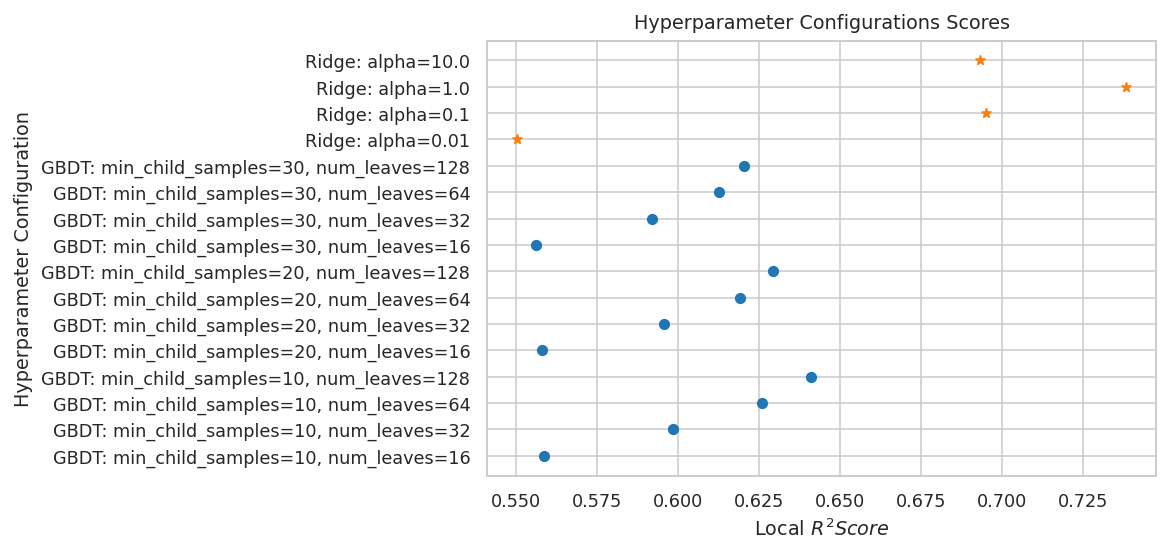

In [13]:
sns.set_context('paper')
sns.set_style('whitegrid')
fig, ax = plt.subplots()
ax.scatter(
    np.array([0.55861602, 0.59848909, 0.62589313, 0.64106557, 0.55793461,
        0.59584444, 0.6189854, 0.62923806, 0.55619112, 0.59194587,
        0.6126917 , 0.62047748]
     ),
    [
        f"GBDT: min_child_samples={p['reg__min_child_samples']}, num_leaves={p['reg__num_leaves']}"
        for p in [
            {'reg__min_child_samples': 10, 'reg__num_leaves': 16},
            {'reg__min_child_samples': 10, 'reg__num_leaves': 32},
            {'reg__min_child_samples': 10, 'reg__num_leaves': 64},
            {'reg__min_child_samples': 10, 'reg__num_leaves': 128},
            {'reg__min_child_samples': 20, 'reg__num_leaves': 16},
            {'reg__min_child_samples': 20, 'reg__num_leaves': 32},
            {'reg__min_child_samples': 20, 'reg__num_leaves': 64},
            {'reg__min_child_samples': 20, 'reg__num_leaves': 128},
            {'reg__min_child_samples': 30, 'reg__num_leaves': 16},
            {'reg__min_child_samples': 30, 'reg__num_leaves': 32},
            {'reg__min_child_samples': 30, 'reg__num_leaves': 64},
            {'reg__min_child_samples': 30, 'reg__num_leaves': 128}
        ]
    ],
    c='#1f77b4',
    marker='o'
)
ax.scatter(
    np.array([0.55046961, 0.69483763, 0.73813124, 0.69320247]),
    [
        f"Ridge: alpha={p['reg__alpha']}"
        for p in [
            {'reg__alpha': 0.01},
            {'reg__alpha': 0.1},
            {'reg__alpha': 1.0},
            {'reg__alpha': 10.0}
        ]
    ],
    c='#ff7f0e',
    marker='*'
)

ax.set_xlabel('Local $R^2 Score$')
ax.set_ylabel('Hyperparameter Configuration')
ax.set_title('Hyperparameter Configurations Scores')

In [14]:
fig.savefig('hyp_conf_scores.pdf', bbox_inches='tight', dpi=300)

In [15]:
import scipy

/home/andrea/venv-environments/polito-dsl/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of the quality attribute')

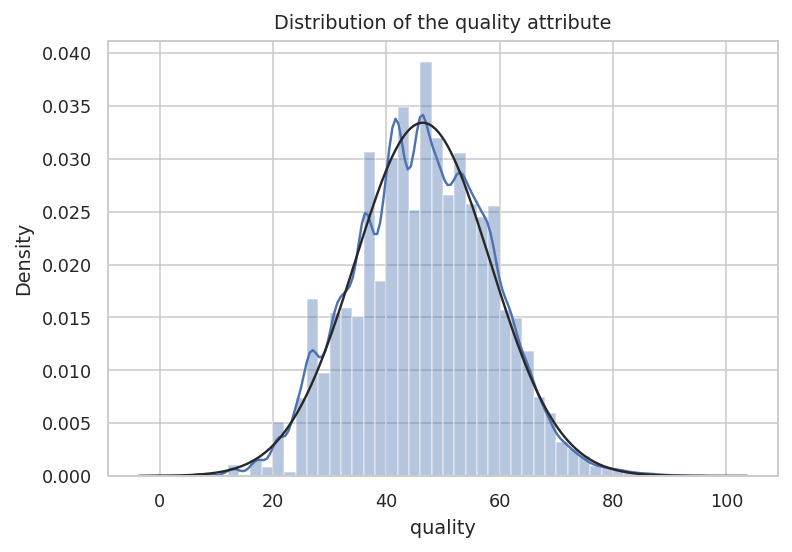

In [16]:
fig, ax = plt.subplots()
sns.distplot(df.quality, ax=ax, fit=scipy.stats.norm)
ax.set_title('Distribution of the quality attribute')

In [17]:
fig.savefig('quality.pdf', bbox_inches='tight', dpi=300)

---


## Ridge Model Interpretability Analysis

In [19]:
coeffs = ridge_search.best_estimator_['reg'].coef_
intercept = ridge_search.best_estimator_['reg'].intercept_
coeffs, intercept

(array([ -0.17133959, -10.39362467,  -0.15061175, ...,   4.30227498,
         -1.85741641,  -1.20788631]),
 40.76030801393754)

In [20]:
vocabulary = TfidfVectorizer(stop_words=stopwords.words('english')).fit(X_train.description).vocabulary_
vocabulary_words = [v for k,v in sorted([(v,k) for k,v in vocabulary.items()], key=lambda t: t[0])]
vocabulary_words[20000:20010]

['saturating',
 'saturation',
 'saturn',
 'satz',
 'satèn',
 'satén',
 'sauce',
 'sauced',
 'sauces',
 'sauciness']

In [21]:
import itertools

In [22]:
categories = list(itertools.chain(*OneHotEncoder(handle_unknown='ignore').fit(X_train[categorical_columns]).categories_))
categories[1000:1005]

['Verdeca', 'Verdejo', 'Verdejo-Sauvignon Blanc', 'Verdejo-Viura', 'Verdelho']

In [23]:
assert len(vocabulary_words) + len(categories) == coeffs.shape[0]

In [24]:
feature_coef = [
    (f, c) for f,c in zip(vocabulary_words + categories, coeffs)
]
feature_coef = sorted(feature_coef, key=lambda t: t[1])

### Worst Features

In [25]:
for feature, c in feature_coef[:20]:
    print(f"{feature.rjust(30)} = {c:.2f}")

         Napa Family Vineyards = -19.48
                        Bandit = -17.58
                      Landshut = -17.55
                      Terrenal = -17.19
                         value = -16.65
                   Pine & Post = -16.24
                 Toca Diamonte = -15.97
                     Two Vines = -15.78
                      StoneCap = -15.66
          Herdade dos Machados = -15.41
                      Hilltown = -15.37
                     Oak Grove = -15.14
                   Funky Llama = -15.12
                     Backhouse = -14.93
                     Two Vines = -14.76
                      Pavilion = -14.70
              Saurus Patagonia = -14.35
            Kirkland Signature = -14.32
                    House Band = -14.16
                            87 = -14.13


### Best Features

In [26]:
for feature, c in feature_coef[::-1][:20]:
    print(f"{feature.rjust(30)} = {c:.2f}")

                        Grange = 22.97
               Viñedo Chadwick = 21.48
                    Montrachet = 21.25
                           Kai = 20.86
     Rivalta Limited Selection = 19.82
                         Blair = 19.27
                          Gaja = 18.89
                      Contador = 18.38
             40-year old tawny = 18.28
             Bâtard-Montrachet = 17.82
                       Antiyal = 17.21
                        Artadi = 17.09
          Chevalier-Montrachet = 17.00
               Finca El Bosque = 16.93
                 Harlan Estate = 16.75
              Dal Forno Romano = 16.73
              Auma Los Lingues = 16.66
                         Viu 1 = 16.55
               Carmín de Peumo = 16.38
                     La Cumbre = 16.30


In [27]:
for feature, c in feature_coef[::-1][:20]:
    print(f"{feature.rjust(30)} = {c:.2f}")

                        Grange = 22.97
               Viñedo Chadwick = 21.48
                    Montrachet = 21.25
                           Kai = 20.86
     Rivalta Limited Selection = 19.82
                         Blair = 19.27
                          Gaja = 18.89
                      Contador = 18.38
             40-year old tawny = 18.28
             Bâtard-Montrachet = 17.82
                       Antiyal = 17.21
                        Artadi = 17.09
          Chevalier-Montrachet = 17.00
               Finca El Bosque = 16.93
                 Harlan Estate = 16.75
              Dal Forno Romano = 16.73
              Auma Los Lingues = 16.66
                         Viu 1 = 16.55
               Carmín de Peumo = 16.38
                     La Cumbre = 16.30


### Worst Textual Features

In [28]:
vw_set = set(vocabulary_words)
textual_feature_coef = [
    (f, c) for f,c in zip(vocabulary_words + categories, coeffs) if f in vw_set
]
textual_feature_coef = sorted(textual_feature_coef, key=lambda t: t[1])

In [29]:
for feature, c in textual_feature_coef[:10]:
    print(f"{feature.rjust(30)} = {c:.2f}")

                         value = -16.65
                            87 = -14.13
                           buy = -12.58
                       bargain = -12.47
                         price = -12.17
                            88 = -11.51
                   inexpensive = -10.99
                           000 = -10.39
                    affordable = -9.61
                        budget = -9.59


In [30]:
for d in df.description[df.description.str.contains('000 ')][:5]: print(d, end='\n\n')

The bouquet is fairly tight, with aromas of coffee, crushed minerals, crude oil and fine herbs. The palate runs snappier than most high-end Malbecs, but it also delivers on the promise of ripeness and black-fruit flavors. Finishes in healthy fashion, with some slickness and speed. Very nice and likely even better with food. 1,000 cases made. Imported by Slocum & Sons.

Supple and easy to drink, this is as good an introduction to Cote-Rotie as any. Minerally and tinged with beef blood on the nose, then showing solid berry flavors accented by herbal notes on the palate. Develops meaty notes on the finish. With 25,000 cases produced, it's the Cote-Rotie consumers are most likely to find.

Adelsheim makes 9,000 cases of this full-flavored Pinot Gris, one of the best in Oregon. A rich texture and fleshy fruit highlighted by cinnamon-dusted pears is enhanced by hints of mint and marzipan.

As expected, the wine exhibits a dense black color, with mineral, burnt toast and dark fruit on the bou

In [31]:
for feature, c in textual_feature_coef[::-1][:10]:
    print(f"{feature.rjust(30)} = {c:.2f}")

                          2022 = 13.71
                 beerenauslese = 12.73
                          2020 = 12.55
                     carmenère = 12.45
                       eiswein = 12.35
                      flagship = 12.07
                          2040 = 11.28
                          2030 = 11.14
                            98 = 10.76
                        purest = 10.54


Why are these future years here?

In [32]:
for d in df.description[df.description.str.contains('2040')][:5]: print(d, end='\n\n')

This has all the size and weight you've come to expect from Australia's most famous wine. Huge fruit and huge oak combine in a full-bodied, richly textured package that delivers waves of toasted coconut, vanilla and intense dark berries yet remains embryonic more than five years after the harvest. That said, the texture isn't quite as tight or as fine as some other vintages—expect this to be early maturing by Grange standards, and best from 2020–2040.

Dense and rich but also incredibly complex, long and elegant, this is a momumental Côte-Rôtie. It's darkly fruited and superripe, yet doesn't lose its essential sense of terroir, remaining marked by scents of pepper and espresso to go with the chocolate and cassis fruit. Velvety in texture, this is the one of Guigal's 2003 Côte-Rôties that demands a few years of cellaring. Drink 2010–2040.

This supremely elegant and age-worthy Sassicaia opens with an intense bouquet of black cherry, Mediterranean herbs, blue flower, cedar and leather ar

---

## Running the model on the evaluation dataset

In [ ]:
df_eval = pd.read_csv('../datasets/competition_dataset/eval.tsv', sep='\t', dtype=dtypes, usecols=[k for k in dtypes.keys() if k != 'quality'])

df_eval = df_eval.dropna(subset=['country', 'province'])

for col in categorical_columns:
    unk_cat = f"UNKNOWN_{col}"
    df_eval[col] = df_eval[col].cat.add_categories(unk_cat).fillna(unk_cat)
df_eval

In [ ]:
reg_eval = search.fit(df.drop('quality', axis=1), df.quality)
df_eval['Predicted'] = reg_eval.predict(df_eval)
df_eval['Predicted']

In [ ]:
df_eval['Predicted'].to_csv('second.csv',index_label='Id')

---

## Exporting transformed datasets for colab Neural Network training

In [ ]:
from scipy.sparse import save_npz

In [ ]:
fitted_column_trans = column_trans.fit_transform(X_train)

In [ ]:
column_trans.transform(X_train).shape

In [ ]:
save_npz('X_train', column_trans.transform(X_train))

In [ ]:
column_trans.transform(X_test).shape

In [ ]:
save_npz('X_test', column_trans.transform(X_test))

In [ ]:
y_train.to_numpy().shape

In [ ]:
np.save('y_train',y_train.to_numpy())

In [ ]:
y_test.to_numpy().shape

In [ ]:
np.save('y_test',y_test.to_numpy())

In [ ]:
save_npz('X_eval', column_trans.transform(df_eval))